In [1]:
import keras
import numpy as np
from keras.datasets import mnist
from keras.layers import *
from keras.models import Model, Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib notebook

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
def preprocess_X(X):
    X = X[..., np.newaxis]
    X = (X.astype(np.float32) - 127.5)/127.5
    return X

X_train = preprocess_X(X_train)
X_test = preprocess_X(X_test)

In [4]:
def assemble_discriminator():
    input_x = Input(shape=(28, 28, 1))
    x = input_x
    
    x = Conv2D(64, 5, 5, border_mode='same')(x)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, 5, 5)(x)
    x = Activation('tanh')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = Activation('tanh')(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    
    return Model(input=input_x, output=x)

In [5]:
def assemble_generator(z_dim):
    input_x = Input(shape=(z_dim,))
    x = input_x
    
    x = Dense(1024)(x)
    x = Activation('tanh')(x)
    x = Dense(128*7*7)(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = Reshape((7, 7, 128))(x)
    
    x = UpSampling2D(size=(2, 2))(x) # 14x14
    x = Convolution2D(64, 5, 5, border_mode='same')(x)
    x = Activation('tanh')(x)
    
    x = UpSampling2D(size=(2, 2))(x) # 28x28
    x = Convolution2D(1, 5, 5, border_mode='same')(x)
    x = Activation('tanh')(x)
    
    return Model(input=input_x, output=x)

In [6]:
z_dim = 100
generator = assemble_generator(z_dim)
discriminator = assemble_discriminator()
adversarial = Sequential()
adversarial.add(generator)
adversarial.add(discriminator)

generator.summary()
discriminator.summary()
adversarial.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1024)          103424      input_1[0][0]                    
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1024)          0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 6272)          6428800     activation_1[0][0]               
___________________________________________________________________________________________

In [7]:
discriminator.trainable = False
adversarial.compile(
    optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True),
    loss='binary_crossentropy'
)
discriminator.trainable = True

discriminator.compile(
    optimizer=SGD(lr=0.0005, momentum=0.9, nesterov=True),
    loss='binary_crossentropy'
)

In [8]:
def create_image_grid(images):
    n = int(round(np.sqrt(len(images))))
    images = images.reshape(images.shape[:-1])
    i_h = images.shape[1]
    i_w = images.shape[2]
    grid = np.zeros((n*i_h, n*i_w))
    for r in range(n):
        for c in range(n):
            grid[r*i_h:(r+1)*i_h, c*i_w:(c+1)*i_w] = images[r*n+c, ...]
    return grid

In [9]:
batch_size = 128
epochs = 30
epoch = 0

X = X_train
y = y_train

d_loss_epoch = []
g_loss_epoch = []

<IPython.core.display.Javascript object>


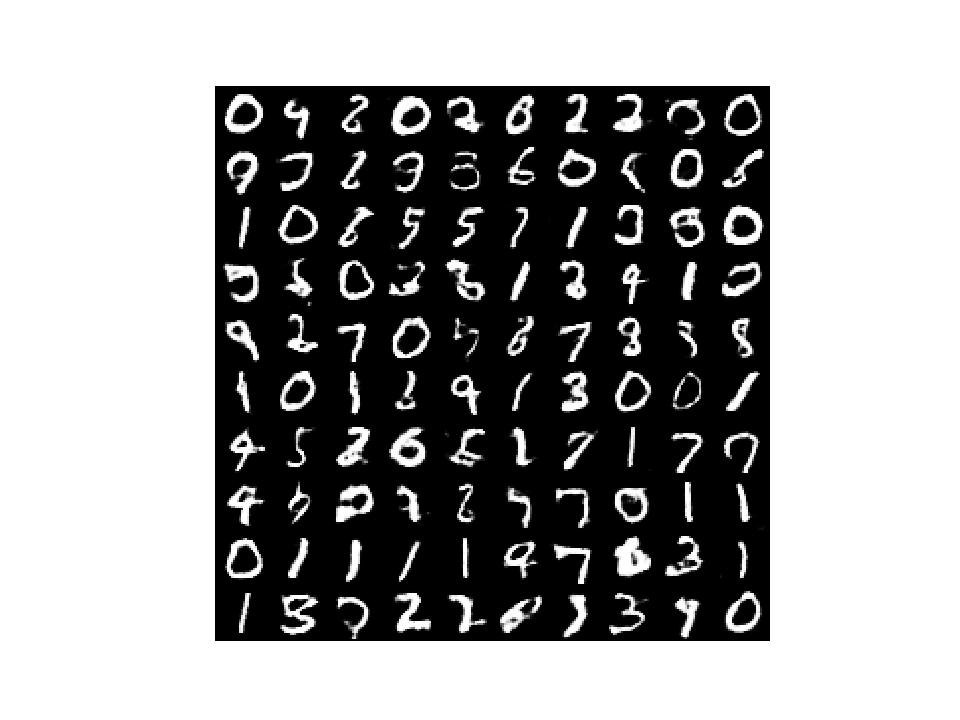

<IPython.core.display.Javascript object>


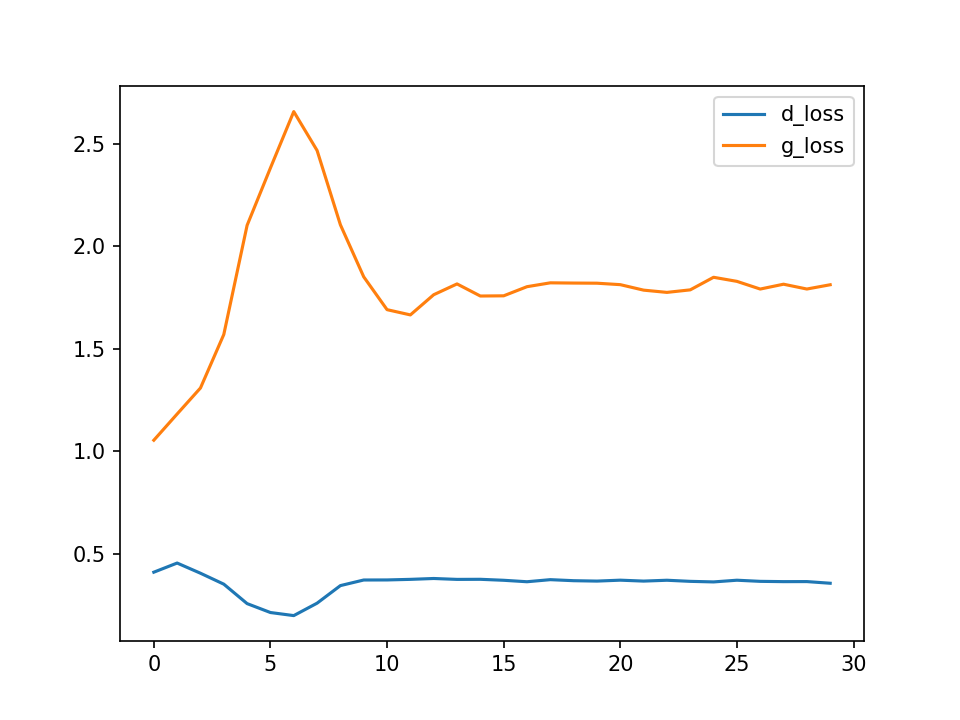

In [10]:
output_fig = plt.figure()
output_ax = output_fig.add_subplot(111)
output_ax.axis('off')
output_fig.show()

loss_fig = plt.figure()
loss_ax = loss_fig.add_subplot(111)
loss_fig.show()

batches_per_epoch = len(X) // batch_size
for e in tqdm_notebook(range(epochs), desc='Running'):
    epoch += 1
    
    d_losses = []
    g_losses = []
    for i in tqdm_notebook(range(batches_per_epoch), desc='Epoch {}'.format(epoch), leave=False):
        # Discriminator
        real_X = X[np.random.randint(0, len(X), batch_size//2), ...]
        
        z = np.random.uniform(-1.0, 1.0, size=(batch_size//2, z_dim))
        fake_X = generator.predict(z)
        
        X_batch = np.concatenate((real_X, fake_X))
        y_batch = np.zeros((batch_size, 1))
        y_batch[:batch_size//2] = 1
        d_loss = discriminator.train_on_batch(X_batch, y_batch)
        d_losses.append(d_loss)
        
        # Generator
        z = np.random.uniform(-1.0, 1.0, size=(batch_size, z_dim))
        y_batch = np.ones((batch_size, 1))
        g_loss = adversarial.train_on_batch(z, y_batch)
        g_losses.append(g_loss)
    
    d_loss_epoch.append(sum(d_losses) / len(d_losses))
    g_loss_epoch.append(sum(g_losses) / len(g_losses))
    
    z = np.random.uniform(-1.0, 1.0, size=(10**2, z_dim))
    fake_images = generator.predict(z)

    output_ax.imshow(create_image_grid(fake_images), cmap='gray')
    output_fig.canvas.draw()
    
    loss_ax.clear()
    loss_ax.plot(np.arange(len(d_loss_epoch)), d_loss_epoch, label='d_loss')
    loss_ax.plot(np.arange(len(g_loss_epoch)), g_loss_epoch, label='g_loss')
    loss_ax.legend()
    loss_fig.canvas.draw()

In [11]:
with open('generator.json', 'w') as f:
    f.write(generator.to_json())
generator.save_weights('generator.h5')